# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [2]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [3]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [4]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [5]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [6]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [7]:
your_name = 'saggy' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [8]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [9]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
1178,23,female,33.81905,0,no,2986.474030
1295,20,male,21.34000,1,no,2023.723400
205,28,female,28.01360,1,no,4467.867256
1067,39,male,41.37535,0,no,5930.135853
523,38,female,36.59810,0,no,5559.545201


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [10]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [11]:
num_cols = dataframe.shape[1]
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [12]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']
print(input_cols)

['age', 'sex', 'bmi', 'children', 'smoker']


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [13]:
categorical_cols = ['sex','smoker']
categorical_cols

['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [14]:
output_cols = ['charges']
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [15]:
dataframe["charges"].describe()


count     1271.000000
mean     13715.229636
std      12568.488501
min       1155.530117
25%       4870.872446
50%       9697.367600
75%      17079.602763
max      65683.540850
Name: charges, dtype: float64

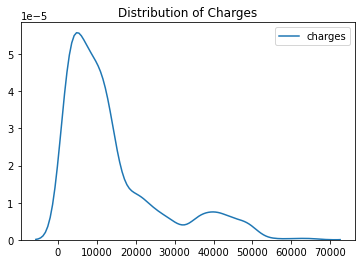

In [16]:
import seaborn as sns

plt.title("Distribution of Charges")
sns.kdeplot(dataframe['charges'])

#sns.distplot(dataframe.charges);

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [17]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sagnik2019/02-insurance-linear-regression


<IPython.core.display.Javascript object>

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [18]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [19]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[23.     ,  0.     , 33.81905,  0.     ,  0.     ],
        [20.     ,  1.     , 21.34   ,  1.     ,  0.     ],
        [28.     ,  0.     , 28.0136 ,  1.     ,  0.     ],
        ...,
        [53.     ,  0.     , 25.899  ,  2.     ,  0.     ],
        [26.     ,  1.     , 26.2482 ,  0.     ,  1.     ],
        [19.     ,  0.     , 27.4607 ,  0.     ,  1.     ]]),
 array([[ 2986.4740305],
        [ 2023.7234   ],
        [ 4467.867256 ],
        ...,
        [11485.3034   ],
        [17554.641642 ],
        [17993.053417 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [20]:
inputs = torch.Tensor(inputs_array)
targets = torch.Tensor(targets_array)

In [21]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [22]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [23]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [24]:
batch_size = 10

In [25]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [26]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[57.0000,  1.0000, 28.1057,  0.0000,  1.0000],
        [28.0000,  0.0000, 36.4914,  1.0000,  0.0000],
        [36.0000,  0.0000, 29.1194,  0.0000,  0.0000],
        [41.0000,  1.0000, 28.7508,  5.0000,  0.0000],
        [19.0000,  1.0000, 30.9624,  0.0000,  1.0000],
        [18.0000,  0.0000, 40.9728,  0.0000,  1.0000],
        [60.0000,  1.0000, 24.9678,  0.0000,  0.0000],
        [39.0000,  1.0000, 29.0273,  1.0000,  1.0000],
        [25.0000,  1.0000, 24.9678,  0.0000,  0.0000],
        [42.0000,  0.0000, 24.5410,  1.0000,  0.0000]])
targets: tensor([[28034.9902],
        [ 3879.8904],
        [ 5430.3413],
        [ 9499.0742],
        [34762.8008],
        [39956.4648],
        [12506.8564],
        [23135.9043],
        [ 2201.7832],
        [ 7256.8638]])


Let's save our work by committing to Jovian.

In [27]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sagnik2019/02-insurance-linear-regression


<IPython.core.display.Javascript object>

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [28]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [29]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
       
        
    def forward(self, xb):
        out = self.linear(xb)                        
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        #loss = F.mse_loss(out, targets)                      
        loss = F.l1_loss(out, targets) 
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
       # loss = F.mse_loss(out, targets)                          
        loss = F.l1_loss(out, targets) 
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [30]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [31]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3620,  0.0923, -0.1484, -0.2040,  0.3293]], requires_grad=True),
 Parameter containing:
 tensor([-0.4015], requires_grad=True)]

One final commit before we train the model.

In [32]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sagnik2019/02-insurance-linear-regression


<IPython.core.display.Javascript object>

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [33]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [34]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13084.5908203125}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [35]:
epochs = 500
lr = 1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 6202.8867
Epoch [40], val_loss: 5783.0708
Epoch [60], val_loss: 5386.2158
Epoch [80], val_loss: 4991.6631
Epoch [100], val_loss: 4600.0239
Epoch [120], val_loss: 4239.8623
Epoch [140], val_loss: 3944.4573
Epoch [160], val_loss: 3777.1882
Epoch [180], val_loss: 3668.4539
Epoch [200], val_loss: 3638.7356
Epoch [220], val_loss: 3626.9580
Epoch [240], val_loss: 3622.3040
Epoch [260], val_loss: 3634.8523
Epoch [280], val_loss: 3622.4224
Epoch [300], val_loss: 3639.7368
Epoch [320], val_loss: 3620.5085
Epoch [340], val_loss: 3638.1304
Epoch [360], val_loss: 3655.5762
Epoch [380], val_loss: 3623.7314
Epoch [400], val_loss: 3651.2417
Epoch [420], val_loss: 3629.9902
Epoch [440], val_loss: 3631.6714
Epoch [460], val_loss: 3631.2351
Epoch [480], val_loss: 3644.2952
Epoch [500], val_loss: 3644.5120


In [36]:
epochs = 500
lr = 1e-1
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3637.6484
Epoch [40], val_loss: 3636.2529
Epoch [60], val_loss: 3637.2422
Epoch [80], val_loss: 3637.3979
Epoch [100], val_loss: 3637.2637
Epoch [120], val_loss: 3637.0486
Epoch [140], val_loss: 3637.2168
Epoch [160], val_loss: 3637.0359
Epoch [180], val_loss: 3637.2764
Epoch [200], val_loss: 3638.1394
Epoch [220], val_loss: 3638.9719
Epoch [240], val_loss: 3638.5835
Epoch [260], val_loss: 3639.0293
Epoch [280], val_loss: 3639.8708
Epoch [300], val_loss: 3639.2590
Epoch [320], val_loss: 3639.9771
Epoch [340], val_loss: 3639.8931
Epoch [360], val_loss: 3640.4292
Epoch [380], val_loss: 3640.3250
Epoch [400], val_loss: 3640.4211
Epoch [420], val_loss: 3640.9951
Epoch [440], val_loss: 3640.4111
Epoch [460], val_loss: 3641.2949
Epoch [480], val_loss: 3644.5107
Epoch [500], val_loss: 3642.4412


In [37]:
epochs = 300
lr = 1e-2
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3641.7339
Epoch [40], val_loss: 3641.5125
Epoch [60], val_loss: 3642.0181
Epoch [80], val_loss: 3642.0920
Epoch [100], val_loss: 3641.9873
Epoch [120], val_loss: 3642.1948
Epoch [140], val_loss: 3642.1323
Epoch [160], val_loss: 3642.4707
Epoch [180], val_loss: 3642.1624
Epoch [200], val_loss: 3642.0024
Epoch [220], val_loss: 3642.5522
Epoch [240], val_loss: 3642.1958
Epoch [260], val_loss: 3642.3574
Epoch [280], val_loss: 3642.6064
Epoch [300], val_loss: 3642.2375


In [38]:
epochs = 400
lr = 10
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3725.2688
Epoch [40], val_loss: 3970.9160
Epoch [60], val_loss: 3870.1714
Epoch [80], val_loss: 3968.5464
Epoch [100], val_loss: 3877.5481
Epoch [120], val_loss: 4017.8882
Epoch [140], val_loss: 3918.0354
Epoch [160], val_loss: 3928.9453
Epoch [180], val_loss: 3883.5288
Epoch [200], val_loss: 3881.2446
Epoch [220], val_loss: 4038.5295
Epoch [240], val_loss: 3949.1221
Epoch [260], val_loss: 3990.5620
Epoch [280], val_loss: 4005.1296
Epoch [300], val_loss: 3888.6011
Epoch [320], val_loss: 3861.4824
Epoch [340], val_loss: 4034.4917
Epoch [360], val_loss: 3866.8389
Epoch [380], val_loss: 3879.4839
Epoch [400], val_loss: 3965.1575


In [39]:
epochs = 500
lr = 1e-4
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3961.2056
Epoch [40], val_loss: 3957.2446
Epoch [60], val_loss: 3953.3376
Epoch [80], val_loss: 3949.6152
Epoch [100], val_loss: 3946.0437
Epoch [120], val_loss: 3942.5205
Epoch [140], val_loss: 3939.0728
Epoch [160], val_loss: 3935.7493
Epoch [180], val_loss: 3932.5139
Epoch [200], val_loss: 3929.4692
Epoch [220], val_loss: 3926.6555
Epoch [240], val_loss: 3924.1516
Epoch [260], val_loss: 3921.7219
Epoch [280], val_loss: 3919.3396
Epoch [300], val_loss: 3917.0383
Epoch [320], val_loss: 3914.9038
Epoch [340], val_loss: 3912.8083
Epoch [360], val_loss: 3910.8811
Epoch [380], val_loss: 3908.9746
Epoch [400], val_loss: 3907.1653
Epoch [420], val_loss: 3905.5029
Epoch [440], val_loss: 3903.7759
Epoch [460], val_loss: 3902.1814
Epoch [480], val_loss: 3900.6665
Epoch [500], val_loss: 3899.1772


In [40]:
epochs = 500
lr = 1
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 3910.2898
Epoch [40], val_loss: 3879.4141
Epoch [60], val_loss: 3891.0408
Epoch [80], val_loss: 3869.2898
Epoch [100], val_loss: 3884.8762
Epoch [120], val_loss: 3871.9434
Epoch [140], val_loss: 3886.3955
Epoch [160], val_loss: 3870.9922
Epoch [180], val_loss: 3891.5962
Epoch [200], val_loss: 3870.6633
Epoch [220], val_loss: 3874.0867
Epoch [240], val_loss: 3870.2097
Epoch [260], val_loss: 3879.3469
Epoch [280], val_loss: 3876.8286
Epoch [300], val_loss: 3898.3804
Epoch [320], val_loss: 3887.9778
Epoch [340], val_loss: 3887.5728
Epoch [360], val_loss: 3868.2639
Epoch [380], val_loss: 3903.9663
Epoch [400], val_loss: 3891.6833
Epoch [420], val_loss: 3900.4087
Epoch [440], val_loss: 3872.7549
Epoch [460], val_loss: 3872.7754
Epoch [480], val_loss: 3869.1719
Epoch [500], val_loss: 3870.1184


**Q: What is the final validation loss of your model?**

In [41]:
val_loss = evaluate(model, val_loader)
val_loss

{'val_loss': 3870.118408203125}

Let's log the final validation loss to Jovian and commit the notebook

In [42]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [43]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sagnik2019/02-insurance-linear-regression


<IPython.core.display.Javascript object>

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [44]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [45]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([62.0000,  1.0000, 36.2780,  0.0000,  0.0000])
Target: tensor([13368.7383])
Prediction: tensor(12846.0703)


In [46]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([48.0000,  0.0000, 28.0136,  1.0000,  0.0000])
Target: tensor([9526.9805])
Prediction: tensor(9618.1865)


In [47]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([41.0000,  0.0000, 32.1604,  3.0000,  0.0000])
Target: tensor([8794.4375])
Prediction: tensor(8676.1836)


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [48]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sagnik2019/02-insurance-linear-regression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sagnik2019/02-insurance-linear-regression


<IPython.core.display.Javascript object>